In [1]:
import os
from os import path
import urllib.request
import gzip
import struct
import array

import syft as sy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# relative import
from datasets import mnist, mnist_raw


print(f"{sy.__version__ = }")

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/dk/Desktop/projects/PySyft



Warning: syft is imported in light mode by default.         
To switch to dark mode, please run `sy.options.color_theme = 'dark'`

sy.__version__ = '0.8.1-beta.12'


## 1. Launch the domain, upload the data

In [2]:
node = sy.orchestra.launch(name="dk-domain", dev_mode=True, reset=True)
root_client = node.login(email="info@openmined.org", password="changethis")

SQLite Store Path:
!open file:///tmp/7394e1ec94664623a12883a6a2443efa.sqlite

Logged into dk-domain as GUEST
Logged into dk-domain as <info@openmined.org>


### Load the MNIST dataset

Let's load the raw MNIST images and show with the `mnist_raw` function from `datasets.py`

In [3]:
train_images, train_labels, test_images, test_labels = mnist_raw()

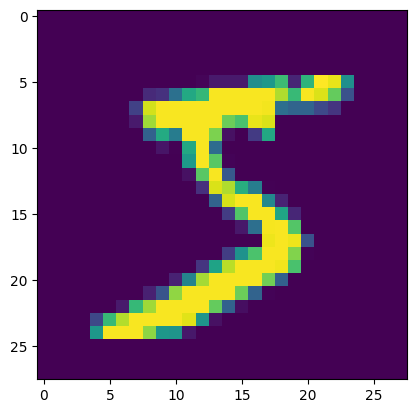

In [4]:
plt.imshow(train_images[0])

In [5]:
train_labels[0]

5

In [6]:
print(f"{train_images.shape = }")
print(f"{train_labels.shape = }")
print(f"{test_images.shape = }")
print(f"{test_labels.shape = }")

train_images.shape = (60000, 28, 28)
train_labels.shape = (60000,)
test_images.shape = (10000, 28, 28)
test_labels.shape = (10000,)


Let's flatten the MNIST images and apply one-hot encoding on the labels using the `mnist` function from `datasets.py`

In [7]:
train_images, train_labels, test_images, test_labels = mnist()

Get a subset of MNIST

In [8]:
num_samples = 1000

In [9]:
train_images = train_images[:num_samples, :] 
train_labels = train_labels[:num_samples, :]

In [10]:
print(f"{train_images.shape = }")
print(f"{train_labels.shape = }")

train_images.shape = (1000, 784)
train_labels.shape = (1000, 10)


The `train_images` and `train_labels` are the private data. Let's create similar mock data with the same shape

In [11]:
mock_images = np.random.rand(num_samples, 784)
mock_images.shape

(1000, 784)

In [12]:
mock_labels = np.eye(10)[np.random.choice(10, num_samples)]
mock_labels.shape

(1000, 10)

In [13]:
assert mock_labels.shape == train_labels.shape
assert mock_images.shape == train_images.shape

### Create the dataset, upload the data

In [14]:
dataset = sy.Dataset(
    name="MNIST data",
    description="""Contains the flattened training images and one-hot encoded training labels.""",
    url="https://storage.googleapis.com/cvdf-datasets/mnist/"
)

dataset.add_contributor(role=sy.roles.UPLOADER, 
                        name="Alice", 
                        email="alice@openmined.com",
                        note="Alice is the data engineer at the OpenMined")

dataset.contributors

[syft.service.dataset.dataset.Contributor]

In [15]:
asset_mnist_train_input = sy.Asset(
    name="MNIST training images",
    description="""The training images of the MNIST dataset""",
    data=train_images,
    mock=mock_images
)

asset_mnist_train_labels = sy.Asset(
    name="MNIST training labels",
    description="""The training labels of MNIST dataset""",
    data=train_labels,
    mock=mock_labels
)

dataset.add_asset(asset_mnist_train_input)
dataset.add_asset(asset_mnist_train_labels)

In [16]:
root_client.upload_dataset(dataset)

  0%|                                                                                                            | 0/2 [00:00<?, ?it/s]

Uploading: MNIST training images


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.21it/s]


Uploading: MNIST training labels


<class 'syft.service.response.SyftSuccess'>: Dataset Added

Let's inspect the uploaded data

In [17]:
datasets = root_client.api.services.dataset.get_all()
assert len(datasets) == 1
datasets

[syft.service.dataset.dataset.Dataset]

In [18]:
datasets[0].assets[0]

syft.service.dataset.dataset.Asset

In [19]:
datasets[0].assets[1]

syft.service.dataset.dataset.Asset

### Create an account for the Data Scientist (DS)

In [20]:
root_client.register(name="Sheldon Cooper",
                     email="sheldon@caltech.edu",
                     password="changethis",
                     institution="Caltech",
                     website="https://www.caltech.edu/")

<class 'syft.service.response.SyftSuccess'>: User Sheldon Cooper successfully registered! To see users, run client.users.

### Now switch to the DS's notebook

## 2. After the DS submits code execution requests, DO review and approve the code

In [21]:
root_client.projects

In [22]:
requests = root_client.projects[0].requests
requests

[syft.service.request.request.Request]

In [23]:
request = requests[0]
request

syft.service.request.request.Request

In [24]:
change = request.changes[0]
change

```python
class UserCodeStatusChange:
  id: b79e4b4811e344e5851a9180c359454d
  function: mnist_3_linear_layers
  input_policy_type: ExactMatch
  output_policy_type: OutputPolicyExecuteOnce
  approved: False
```

In [25]:
# gettting a reference to the user code object
user_code = change.link

# viewing the actual code submitted for request
print(user_code.code)

@sy.syft_function(input_policy=sy.ExactMatch(mnist_images=mock_images_ptr, mnist_labels=mock_labels_ptr),
                  output_policy=sy.SingleExecutionExactOutput())
def mnist_3_linear_layers(mnist_images, mnist_labels):
    # import the packages
    import jax
    from jax.example_libraries import stax
    from jax.example_libraries.stax import Dense, Relu, LogSoftmax
    import time
    from jax.example_libraries import optimizers
    import itertools
    import jax.numpy as jnp
    import numpy.random as npr
    from jax import jit, grad, random
    
    # define the neural network
    init_random_params, predict = stax.serial(
        Dense(1024), Relu,
        Dense(1024), Relu,
        Dense(10), LogSoftmax)
    
    # initialize the random parameters
    rng = random.PRNGKey(0)
    _, init_params = init_random_params(rng, (-1, 784))
    
    # the hyper parameters
    num_epochs = 10
    batch_size = 4
    num_train = mnist_images.shape[0]
    num_complete_batches, leftover

In [26]:
user_code.assets

[syft.service.dataset.dataset.Asset, syft.service.dataset.dataset.Asset]

In [27]:
mock_images = user_code.assets[0].mock
print(f"{mock_images.shape = }")
mock_labels = user_code.assets[1].mock
print(f"{mock_labels.shape = }")

mock_images.shape = (1000, 784)
mock_labels.shape = (1000, 10)


In [28]:
# private data associated with the asset
private_images = user_code.assets[0].data
print(f"{private_images.shape = }")
private_labels = user_code.assets[1].data
print(f"{private_labels.shape = }")

private_images.shape = (1000, 784)
private_labels.shape = (1000, 10)


In [29]:
users_function = user_code.unsafe_function
mock_result = users_function(mnist_images=mock_images, mnist_labels=mock_labels)
mock_result


Starting training...
Epoch 0 in 2.24 sec
Training set accuracy 0.17500001192092896
Epoch 1 in 1.95 sec
Training set accuracy 0.28600001335144043
Epoch 2 in 1.83 sec
Training set accuracy 0.34800001978874207
Epoch 3 in 1.75 sec
Training set accuracy 0.5240000486373901
Epoch 4 in 1.96 sec
Training set accuracy 0.5910000205039978
Epoch 5 in 1.81 sec
Training set accuracy 0.3830000162124634
Epoch 6 in 1.96 sec
Training set accuracy 0.7090000510215759
Epoch 7 in 1.84 sec
Training set accuracy 0.7120000123977661
Epoch 8 in 1.79 sec
Training set accuracy 0.8250000476837158
Epoch 9 in 1.77 sec
Training set accuracy 0.8760000467300415


In [30]:
real_result = users_function(mnist_images=private_images, mnist_labels=private_labels)
real_result


Starting training...
Epoch 0 in 1.88 sec
Training set accuracy 0.8290000557899475
Epoch 1 in 1.80 sec
Training set accuracy 0.8840000629425049
Epoch 2 in 1.95 sec
Training set accuracy 0.9200000166893005
Epoch 3 in 1.85 sec
Training set accuracy 0.937000036239624
Epoch 4 in 1.71 sec
Training set accuracy 0.9530000686645508
Epoch 5 in 1.74 sec
Training set accuracy 0.9670000672340393
Epoch 6 in 1.85 sec
Training set accuracy 0.9770000576972961
Epoch 7 in 1.78 sec
Training set accuracy 0.9780000448226929
Epoch 8 in 2.03 sec
Training set accuracy 0.9900000691413879
Epoch 9 in 1.88 sec
Training set accuracy 0.9970000386238098
